In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from NoiseKD import Teacher

First hurdle. the embedding layer.  It requires the ints as inputs, not one hot.  i need one hot.  i will also need to rewire the LLM i use to do the same.  hmm.  save the weights, load it into a model that has the same shapes, but accepts one hot arrays, not vocab_indexes.

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout, batch_first = True),
            num_layers
        )

    def forward(self, x):
        return self.transformer(x)

class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout):
        super(SimpleLanguageModel, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define the transformer encoder
        self.transformer_encoder = TransformerEncoder(embedding_dim, num_heads, hidden_dim, num_layers, dropout)
        
        self.fc1 = nn.Linear(sequence_length*embedding_dim, 1000)
        self.fc2 = nn.Linear(1000, 500)
        
        self.output_layer = nn.Linear(500, class_num)
        
        

    def forward(self, input_data):
        # Input_data is of shape (batch_size, sequence_length)
        # Apply embedding layer
        #print(input_data.shape)
        embedded = self.embedding(input_data)
        #print(embedded.shape)
        # Pass through the transformer encoder
        transformed = self.transformer_encoder(embedded)
        #print(transformed.shape) #same as input duh: batch x sequence_length x embedding_dim
        flattened_tensor = transformed.view(-1,sequence_length*embedding_dim)
        f1 = F.relu(self.fc1(flattened_tensor))
        
        f2 = F.relu(self.fc2(f1))
        out = self.output_layer(f2)
        # Apply the output layer
        output = F.softmax(out) # should be output = F.softmax(out,dim=-1) or output = F.softmax(out,dim=1)

        return output
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [4]:
embedding_dim = 16
num_heads = 8
hidden_dim  = 11
num_layers = 2
dropout = 0.1 #tried with zero, same prob...
vocab_size = 80
class_num = vocab_size
batch_size = 23
sequence_length = 160

In [5]:
SLM = SimpleLanguageModel(vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout)

In [6]:
SLM

SimpleLanguageModel(
  (embedding): Embedding(80, 16)
  (transformer_encoder): TransformerEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=11, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=11, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
       

In [7]:
input_data = torch.randint(low=0, high=vocab_size, size=(batch_size, sequence_length))
print(input_data.shape)
SLM(input_data).shape

torch.Size([23, 160])


/var/folders/hq/zz_5zb251633yqqbh6076p782zzx8q/T/ipykernel_29234/1983935209.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(out) # should be output = F.softmax(out,dim=-1) or output = F.softmax(out,dim=1)


torch.Size([23, 80])

In [8]:
count_parameters(SLM)

3105922

In [9]:
teacher_slm = Teacher(SLM,(sequence_length,)) #don't specify batch!!

In [10]:
teacher_slm.load_state_dict('good_teacher.pth')

Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)
lets try ints!


/var/folders/hq/zz_5zb251633yqqbh6076p782zzx8q/T/ipykernel_29234/1983935209.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(out) # should be output = F.softmax(out,dim=-1) or output = F.softmax(out,dim=1)


In [ ]:
#model.load_state_dict(torch.load('model_state.pth'))
#model.eval()  

In [ ]:
##some of these configs made for more diverse outputs in teachers:
config_args = {"dist_type" : "ints" ##worked well
                      , "gen_m" : vocab_size
                      , "gen_n" : 100
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_epochs = {"dist_type" : "ints" ##okay, but not as well as config_args.
                      , "gen_m" : vocab_size
                      , "gen_n" : 1000
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_higher_lr = {"dist_type" : "ints" ##lower was worse.  raise it. 0.003 looks great.  this is the best.
                      , "gen_m" : vocab_size
                      , "gen_n" : 2000
                      , "gen_epochs" : 50
                      , "gen_lr" :  0.003 ##0.003
                      , "random_shuffle" : 0.8
                      , "out_type" : "one-hot" }

config_args_less_data = {"dist_type" : "ints" ##worse
                      , "gen_m" : vocab_size
                      , "gen_n" : 500
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.003
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_shuffle = {"dist_type" : "ints" ##one bar..
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.9
                      , "out_type" : "one-hot" }

config_args_small_batch = {"dist_type" : "ints" ##this one was the first to do well.  not just one bar and the rest nearly zero.
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.5
                      , "batch_size" : 10
                      , "out_type" : "one-hot" }

config_ab = {"dist_type" : "ints" ##worked well
                      , "gen_m" : vocab_size
                      , "gen_n" : 5000
                      , "gen_epochs" : 200
                      , "gen_lr" : 0.005
                      , "random_shuffle" : 0.0
                      , "out_type" : "one-hot" 
                      , "dist_type" : 'hetero'
                      , "alpha" : 1
                      , "beta" : 4} #maybe increase epochs?

In [ ]:
#teacher_slm.configure(**config_ab) #this is dying.  might be time for colab!!

In [11]:

args = { 'val_train' : "val"
                      , 'n' : 10_000
                      , 'dist_type' : 'ints'
                      , 'm' : vocab_size
                      , 'std': 1.0
                      , 'alpha' : 1
                      , 'beta' : 3
                      , 'store_outputs' : True
        }
teacher_slm.generate_data(**args)

Generating val data ::   0%|                            | 0/200 [00:00<?, ?it/s]/var/folders/hq/zz_5zb251633yqqbh6076p782zzx8q/T/ipykernel_29234/1983935209.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(out) # should be output = F.softmax(out,dim=-1) or output = F.softmax(out,dim=1)
Generating val data ::   0%|                            | 0/200 [00:06<?, ?it/s]


In [ ]:
##torch.save(teacher_slm.model.state_dict(), 'good_teacher.pth')

In [12]:
teacher_slm.model.embedding.weight.detach().numpy() #use this to make the matrix, just linear? not sure.

array([[-1.5425419 ,  0.35136947, -0.03018094, ..., -0.15405135,
         1.7438477 , -0.98630935],
       [-1.6164193 , -1.8916837 , -0.8887659 , ..., -0.15044953,
        -0.22066197, -1.287303  ],
       [ 0.34314165,  0.25870025, -0.93632895, ...,  1.0878774 ,
         0.89934933, -0.45346054],
       ...,
       [ 0.64084125, -1.4381758 ,  1.0926732 , ...,  2.0109196 ,
         0.51697874, -0.04919771],
       [-0.22420782,  1.1749339 ,  0.90297115, ...,  0.2145888 ,
        -0.39479327,  0.79994994],
       [-0.10181472, -0.19704515,  0.46629068, ..., -0.37408283,
         1.2688403 , -0.0953627 ]], dtype=float32)

In [ ]:
 #the code is right, i just need this to be a better dist.

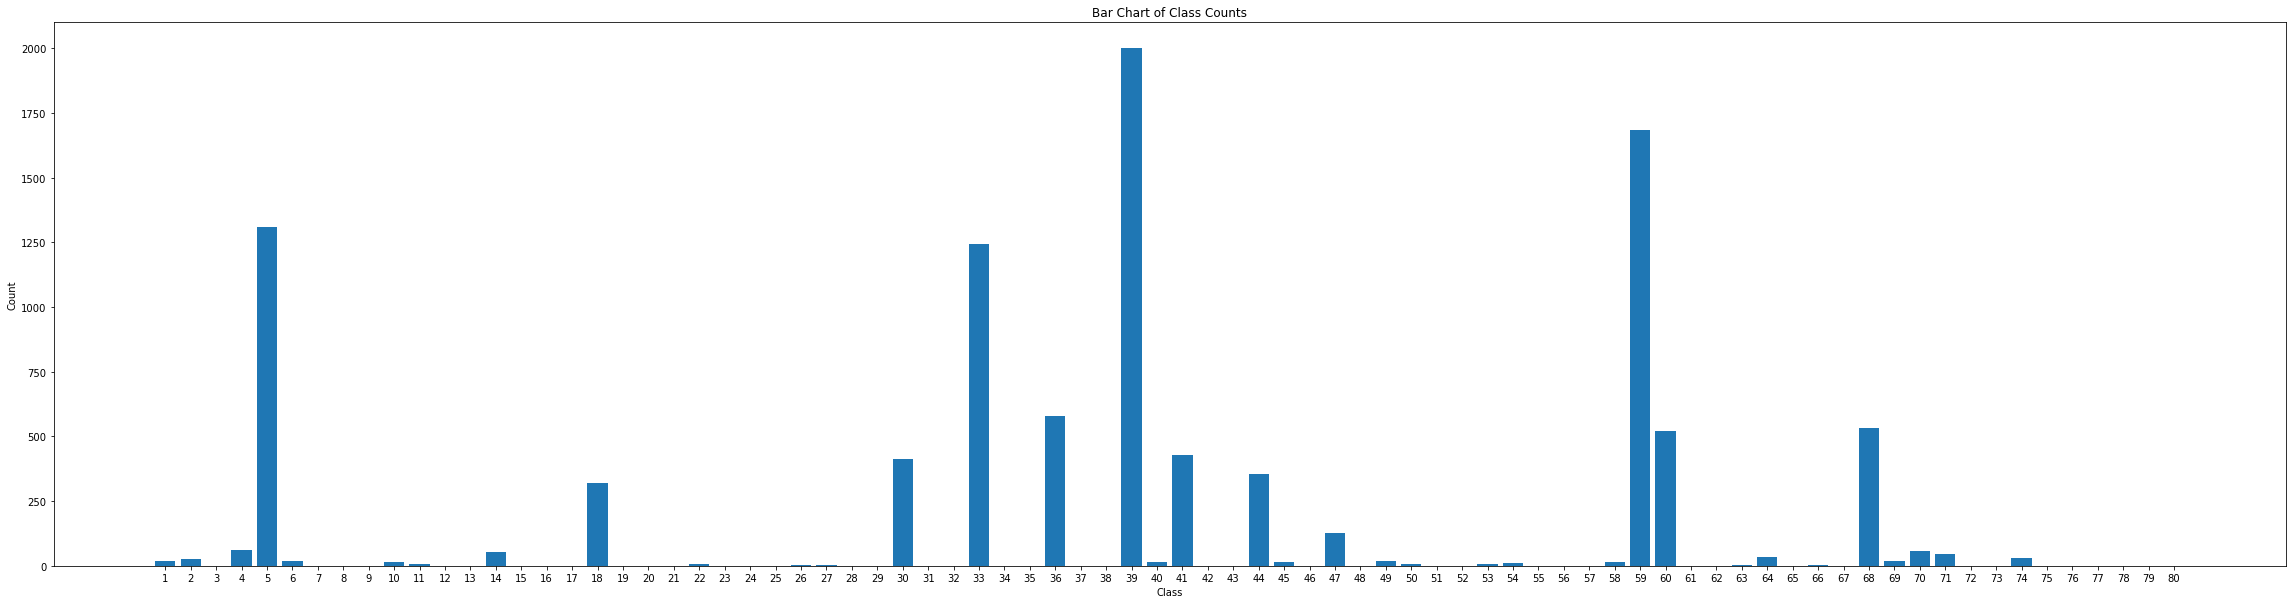

In [13]:
teacher_slm.graph_dataset_dist(val_train = 'val')

In [19]:
#teacher_slm.model.eval() #irrelevant
teacher_slm.model(teacher_slm.val_inputs[50:100])[0], teacher_slm.val_targets[50:60][0]

/var/folders/hq/zz_5zb251633yqqbh6076p782zzx8q/T/ipykernel_29234/1983935209.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(out) # should be output = F.softmax(out,dim=-1) or output = F.softmax(out,dim=1)


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
print(torch.all(teacher_slm.model(teacher_slm.val_inputs[:50]) == teacher_slm.val_targets[:50]))
#in test is concatenated the same way as the outputs in KDNoise.  only difference.  doesn't appear to be different.  
print(torch.all(teacher_slm.model(teacher_slm.val_inputs[50:100]) == teacher_slm.val_targets[50:100])) ##yeah, val_inputs and in_test appear to be the same.
#torch.all(teacher_slm.model(teacher_slm.in_test[:49]) == teacher_slm.val_targets[:49]) ##this doesn't/.  huh???!!
#torch.all(teacher_slm.model(teacher_slm.in_test[:50]) == teacher_slm.model(teacher_slm.val_inputs[:50])) ##okay, these match too
#torch.all(teacher_slm.model(teacher_slm.in_test[223:409]) == teacher_slm.model(teacher_slm.val_inputs[223:409])) #these match.  

In [ ]:
teacher_slm.val_inputs.shape, teacher_slm.val_targets.shape

In [ ]:
torch.all(teacher_slm.model(teacher_slm.val_inputs[1]) ==  teacher_slm.val_targets[1]) ##torch.allclose doesn't work either

so, it looks like it is predicting correctly, but there is something wrong with the batch? they match when you pass in 50, but more, or not at exactly the 50 marks, it doesn't all match.  

In [ ]:
#added teacher_slm.in_test and teacher_slm.dataloader
teacher_slm.data_loader
x = None
y = None
for batch_samples in teacher_slm.data_loader:
    # Perform inference on each batch
    batch_outputs = teacher_slm.model(batch_samples[0])  # Assuming samples are in the first element of the batch
    print(batch_samples[0])
    x = batch_samples[0]
    print(batch_outputs)
    y = batch_outputs
    break

In [ ]:
#okay, the first 50 match.  do they 
torch.all(x == teacher_slm.val_inputs[0:50]),torch.all(y == teacher_slm.val_targets[0:50]),torch.all(teacher_slm.model(x) == y)

In [ ]:
y.shape

specify gen outputs.  we need one hots
i can do this better than chat gpt lol

In [ ]:
##this function works, it is in LABNET.  
def one_hot_last_dim(tensor_shape):
    num_classes = tensor_shape[-1]
    random_idx = np.random.randint(1, num_classes + 1, size=tensor_shape[:-1])
    zero_tensor = np.zeros(tensor_shape, dtype=int)
    last_dim_indices = np.arange(num_classes)
    zero_tensor[..., :, last_dim_indices] = (random_idx[..., np.newaxis] == last_dim_indices)
    return zero_tensor

In [ ]:
axis_to_shuffle = 0

# Shuffle the tensor along the specified axis
shuffled_tensor = np.take(x, np.random.permutation(x.shape[0]), axis=0)

print(shuffled_tensor)


In [ ]:
import random


for i in range(10):
    random_number = random.random()
    print(random_number)

In [ ]:
#next is to extract the parts.  we need to take out the embedding layer, make it linear, and then take out the layer before softmax.  

In [ ]:
import torch.distributions as dist
def generate_heteroskedastic_ints(n, alpha, beta, total_classes):
    # Generate random values from the beta distribution
    values = np.random.beta(alpha, beta, n)
    min_value = 0
    max_value = total_classes
    scaled_values = min_value + (max_value - min_value) * values
    
    # Round the scaled values to integers
    ints = np.round(scaled_values).astype(int)
    
    return ints

# Set your desired alpha and beta values
alpha = 1  # Adjust this to control skewness
beta = 10  # Adjust this to control skewness

# Generate 100 random integers with the specified heteroskedasticity
random_integers = generate_heteroskedastic_ints(10_000, alpha, beta, 100)

# Print the generated integers
print(random_integers)
plt.hist(random_integers, bins=20, edgecolor='k')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Random Integers')
plt.show()


In [ ]:
def generate_heteroskedastic_ints(shape, alpha, beta, total_classes):
    # Generate random values from the beta distribution
    values = np.random.beta(alpha, beta, shape)
    
    # Scale the values to integers in the desired range (e.g., 0 to 100)
    min_value = 0
    max_value = total_classes
    scaled_values = min_value + (max_value - min_value) * values
    
    # Round the scaled values to integers
    ints = np.round(scaled_values).astype(int)
    
    return ints

# Set your desired alpha and beta values
alpha = 1  # Adjust this to control skewness
beta = 1   # Adjust this to control skewness

# Specify the shape of the tensor (e.g., b x 200)
b = 5
shape = (b, 200)

# Generate a tensor of random integers with the specified heteroskedasticity
random_integers_tensor = generate_heteroskedastic_ints(shape, alpha, beta,20)

# Print the generated tensor
random_integers_tensor

In [21]:
class ToyTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout,sequence_length):
        super(ToyTransformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout, batch_first=True),
            num_layers
        )
        self.fc1 = nn.Linear(embedding_dim * sequence_length, vocab_size)  # Intermediate linear layer
        self.fc2 = nn.Linear(vocab_size, vocab_size)  # Final linear layer

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = torch.flatten(x, start_dim=1)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply the intermediate linear layer with ReLU activation
        x = self.fc2(x)  # Apply the final linear layer
        x = F.softmax(x, dim=1)  # Apply softmax activation
        return x

# Set the hyperparameters
embedding_dim = 16
num_heads = 8
hidden_dim = 11
num_layers = 2
dropout = 0.1
vocab_size = 80
class_num = vocab_size
batch_size = 23
sequence_length = 160

# Create an instance of the toy Transformer model
model = ToyTransformer(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout,sequence_length)

# Generate random input data for testing
input_data = torch.randint(0, vocab_size, (batch_size, sequence_length))

# Forward pass through the model
output = model(input_data)

print("Model Output Shape:", output.shape)

Model Output Shape: torch.Size([23, 80])


In [22]:

TT = ToyTransformer(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout,sequence_length)

In [ ]:
teacher_toy = Teacher(TT,(sequence_length,))

In [ ]:
teacher_toy.configure(**config_ab) 

In [ ]:
args = { 'val_train' : "val"
                      , 'n' : 10_000
                      , 'dist_type' : 'ints'
                      , 'm' : vocab_size
                      , 'std': 1.0
                      , 'alpha' : 1
                      , 'beta' : 3
                      , 'store_outputs' : True
        }
teacher_toy.model.eval()
teacher_toy.generate_data(**args)

In [ ]:
#torch.save(teacher_toy.model.state_dict(), 'good_toy.pth')

In [ ]:
teacher_toy.model(teacher_toy.val_inputs[0:10]).shape

In [ ]:
teacher_toy.load_state_dict('good_toy.pth')

In [ ]:
teacher_toy.model.eval()

In [ ]:
TT(teacher_toy.val_inputs[0:1])

In [ ]:
teacher_toy.val_targets[0:1]

In [ ]:
teacher_toy.val_inputs[0:1]

In [ ]:
for i in range(1):
    print(teacher_toy.model(teacher_toy.val_inputs[i:i+1]), teacher_toy.val_targets[i:i+1])

In [ ]:

data_loader = DataLoader(TensorDataset(samples), batch_size=batch_size, shuffle=False)
self.data_loader = data_loader
outputs_list = []
inputs_list = []

total_batches = len(data_loader)

if store_outputs:
    if display_progress:
        progress_bar = tqdm(total=total_batches, desc=f"Generating {val_train} data :")
    self.model.eval()


    for batch_samples in data_loader:
        # Perform inference on each batch
        batch_outputs = self.model(batch_samples[0])  # Assuming samples are in the first element of the batch
        #inputs_list.append(batch_samples[0].detach())
        outputs_list.append(batch_outputs.detach())
        if display_progress:
            progress_bar.update(1)
outputs_return = torch.cat(outputs_list, dim=0)

In [ ]:
for i in range(100):
    print(torch.all(TT(teacher_toy.val_inputs[i:i+1]) == teacher_toy.val_targets[i:i+1]))

In [ ]:
TT.load_state_dict(torch.load('good_toy.pth'))

In [ ]:
TT.eval()

In [ ]:
import numpy as np
gen_shape = (100, sequence_length)
samples = np.random.randint(0, high=vocab_size, size=gen_shape)
samples = torch.from_numpy(samples)

In [ ]:
samples

In [ ]:
#samples = teacher_toy.val_inputs[0:100]
#print(samples)
TT(samples[20:30])[0:1]== TT(samples[20:22])[0:1]

In [ ]:
TT.eval()

# Define batch size
batch_size = 32  # You can adjust this as needed

# Split samples into batches
sample_batches = torch.split(samples, batch_size)

# Create a list to store batched outputs
outputs_list = []

# Forward pass through the model in batches
with torch.no_grad():  
    for batch in sample_batches:
        batch_outputs = TT(batch)
        outputs_list.append(batch_outputs)

# Stack the batched outputs
stacked_outputs = torch.cat(outputs_list, dim=0)

In [ ]:
stacked_outputs.shape, samples.shape

In [ ]:
TT(samples[0:10])[0:1], stacked_outputs[0:1]

In [23]:
count_parameters(TT)

215702